# Johnson-Mehl tessellation picture

I'd like to draw a picture of the Johnson-Mehl tessellation and a Voronoi tessellation so the viewer can compare them.

One interesting fact which I hadn't realised until trying to draw these pictures: the boundaries between cells in the JM tessellation _aren't straight_.

There are algorithms and useful data structures for Voronoi tessellations in the [book by Okabe, Boots, Sugihara and Chiu](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470317013). I've used the algorithm described by Moulinec in ["A simple and fast algorithm for computing discrete Voronoi, Johnson-Mehl or Laguerre diagrams of points"](https://www.sciencedirect.com/science/article/pii/S0965997822000618). Mainly because it's simple, although being fast is also an advantage.

## Outline
1. Sample the arrival times and locations, and prune them.
2. Assign each pixel in an image to its appropriate cell, based on which Johnson-Mehl seed grows to cover it first.
3. Compute adjacency: I want to know which cells border each other so I can colour them appropriately.
4. Colour the cells nicely. It's a planar map, so a four-colouring exists, but I think I'll be a bit simpler and use a greedy colouring, so no two neighbouring cells share a colour but maybe the number of colours isn't completely optimal.

In [1]:
import numpy as np
from scipy.spatial import KDTree
from unconstrained import sample_points, prune_arrivals
from tqdm import trange

### Sampling arrival times and pruning

In [3]:
def get_arrival_times( rho, max_time=1.0, R=0 ):
    N = np.random.poisson(lam=rho*max_time*(1+2*R)**2)
    return np.sort(np.random.uniform(low=0.0, high=max_time, size=N))
# Needs redefining because of my foolishly using a global variable (rng)
# to define the version of this function in unconstrained.py.

In [4]:
rho = 100000

times = get_arrival_times(rho)
seeds = sample_points(len(times))
arrived = prune_arrivals(times, seeds)
print(f'{len(arrived)} out of {len(times)} seeds germinated.')
times = times[arrived]
seeds = seeds[arrived]

1946 out of 100078 seeds germinated.


### Assigning pixels to their cells

This is the bit using Moulinec's method. Moulinec has two separate steps: first assigning the pixels which are covered by time $T$, then the pixels which were not covered by time $T$. He chooses $T$ to optimise the speed of the algorithm. We can simplify the algorithm by choosing $T$ to be the coverage time, then there is no second step.

---

The algorithm works as follows: we start with an array $\mathcal{D}$ of "running minimum coverage times" and an array $\mathcal{I}$ of assignments, both the same shape as the output image. We intialise $\mathcal{D}$ to be full of $\infty$. We order the seeds $x_1, \dots, x_N$ with corresponding arrival times $t_1, \dots, t_N$.

Then for each $i = 1, \dots, N$ in turn: for every pixel $y$ in the ball centred at $x_i$ of radius $T-t_i$, this pixel was first reached by seed $i$ at time $\| x_i - y \| + t_i$. If $\| x_i - y \| + t_i < \mathcal{D}(y)$, then we set $\mathcal{I}(y) = i$ (overwriting its previous value if it had one) and set $\mathcal{D}(y) = \| x_i - y \| + t_i$.

Once we have done this for all $N$ seeds, every pixel is correctly assigned.

In [5]:
def get_ball_pixels(centre, radius, img_size):
    """
    Returns the indices of the pixels in the picture
    corresponding to a ball centred at a point in [0,1]^2
    of a given radius.
    Also saves the corresponding (squared) distances.
    """
    v = (img_size-1)*centre
    x,y = v[0], v[1]
    r = (img_size-1)*radius
    r2 = r*r
    min_i = max( 0, int(x-r) )
    max_i = min( img_size-1, int(x+r)+1 )
    min_j = max( 0, int(y-r) )
    max_j = min( img_size-1, int(y+r)+1 )
    in_ball = []
    sq_distances = []
    for i in range(min_i, max_i+1):
        for j in range(min_j, max_j+1):
            d2 = (x-i)**2 + (y-j)**2
            if d2 <= r2:
                in_ball.append((i,j))
                sq_distances.append(d2)
    return in_ball, sq_distances

def assign_cells( seeds, times, img_size, T=1.0 ):
    """
    Assigns all the pixels in an img_size x img_size picture
    to their respective Johnson-Mehl cells.
    T should be a decent upper bound on the coverage time - smaller T
    means we check fewer points.
    This is (a slightly simplified version of) Moulinec's algorithm.
    """
    min_cov_times = np.full((img_size,img_size),np.inf) # running minimum coverage times
    assignments = np.empty((img_size,img_size),dtype=int)

    for i in trange(len(times)):
        xi = seeds[i]
        ti = times[i]
        indices, d2s = get_ball_pixels(xi, T-ti, img_size)
        for k, ij_pair in enumerate(indices):
            cov_time = np.sqrt(d2s[k])/img_size + ti
            if cov_time < min_cov_times[ij_pair]:
                assignments[ij_pair] = i
                min_cov_times[ij_pair] = cov_time
    return assignments

In [6]:
img_size = 1920

max_time = 2*( (2*np.log(rho) + 4*np.log(np.log(rho))) / (np.pi*rho) )**(1/3)
I = assign_cells(seeds, times, img_size, T=max_time)
# print(I)

100%|███████████████████████████████████████████████████████████████| 1946/1946 [03:29<00:00,  9.31it/s]


### Computing adjacency

The method is easy: for each pixel check if its cell differs from the one below and the one to the right. If they differ, then record the pair of cell IDs in the adjacency matrix. This might be a little slow, but I'm not worried about fast performance; I only plan to use this code to make pretty diagrams, so won't have more than a few hundred cells (probably fewer). As long as the resolution is high enough this will, with high probability, give us the correct adjacency structure.

In [7]:
import networkx # Contains a Graph object which we'll use to store the cell structure.
G = networkx.Graph()
G.add_nodes_from(range(3))
G.add_edge(*(0,1))
print(G)
#networkx.draw(G, with_labels=True)

Graph with 3 nodes and 1 edges


In [8]:
import networkx # Contains a Graph object which we'll use to store the cell structure.
def get_adjacency(cell_assignments):
    G = networkx.Graph()
    #G.add_nodes_from(range(cell_assignments.max()+1)) # Uncomment this to include cells with zero pixels
    N = cell_assignments.shape[0]
    for i in range(N-1): # All columns except the last
        for j in range(N-1): # All rows except the last
            G.add_edge(cell_assignments[i,j], cell_assignments[i+1,j])
            G.add_edge(cell_assignments[i,j], cell_assignments[i,j+1])
        G.add_edge(cell_assignments[i,N-1],cell_assignments[i+1,N-1])
    for j in range(N-1):
        G.add_edge(cell_assignments[N-1,j],cell_assignments[N-1,j+1])
    G.remove_edges_from(networkx.selfloop_edges(G)) # Not necessary for the colouring but if we want to look at the graph structure it makes it a bit cleaner.
    return G

In [9]:
cell_structure = get_adjacency(I)
# networkx.draw(cell_structure, with_labels=False, node_size=20)
print(cell_structure)

Graph with 1943 nodes and 5541 edges


In [10]:
def colour_graph(G):
    """
    Uses a greedy algorithm to colour G.
    The "colours" are just integers, which can be replaced
    with a suitable set of colours when drawing the picture later.
    Even with a few thousand cells I've never seen it use more than
    7 colours.

    Returns a dictionary indexed by the elements of G.nodes
    """
    cells = list(G.nodes).copy()
    colours = dict.fromkeys(G.nodes)
    
    np.random.shuffle(cells)
    for cell in cells:
        new_colour = 0
        while new_colour in [colours[v] for v in G.neighbors(cell)]:
            new_colour += 1
        colours[cell] = new_colour
    return colours

In [11]:
colours = colour_graph(cell_structure)
print(f'We have a {max(colours.values())+1}-colouring of the cells.')
# networkx.draw(cell_structure, node_size=50, node_color=list(colours.values()))

We have a 7-colouring of the cells.


Next we pick suitable colours.

I might two independent colourings of the cells,
so we have colours of the same luminosity and change the brightnesses.
This means it will be a colourful diagram on the screen but will still have a valid colouring when printed in greyscale.

In [12]:
import colorspace
c = colorspace.hcl_palettes().get_palette(name="Blue-Yellow")

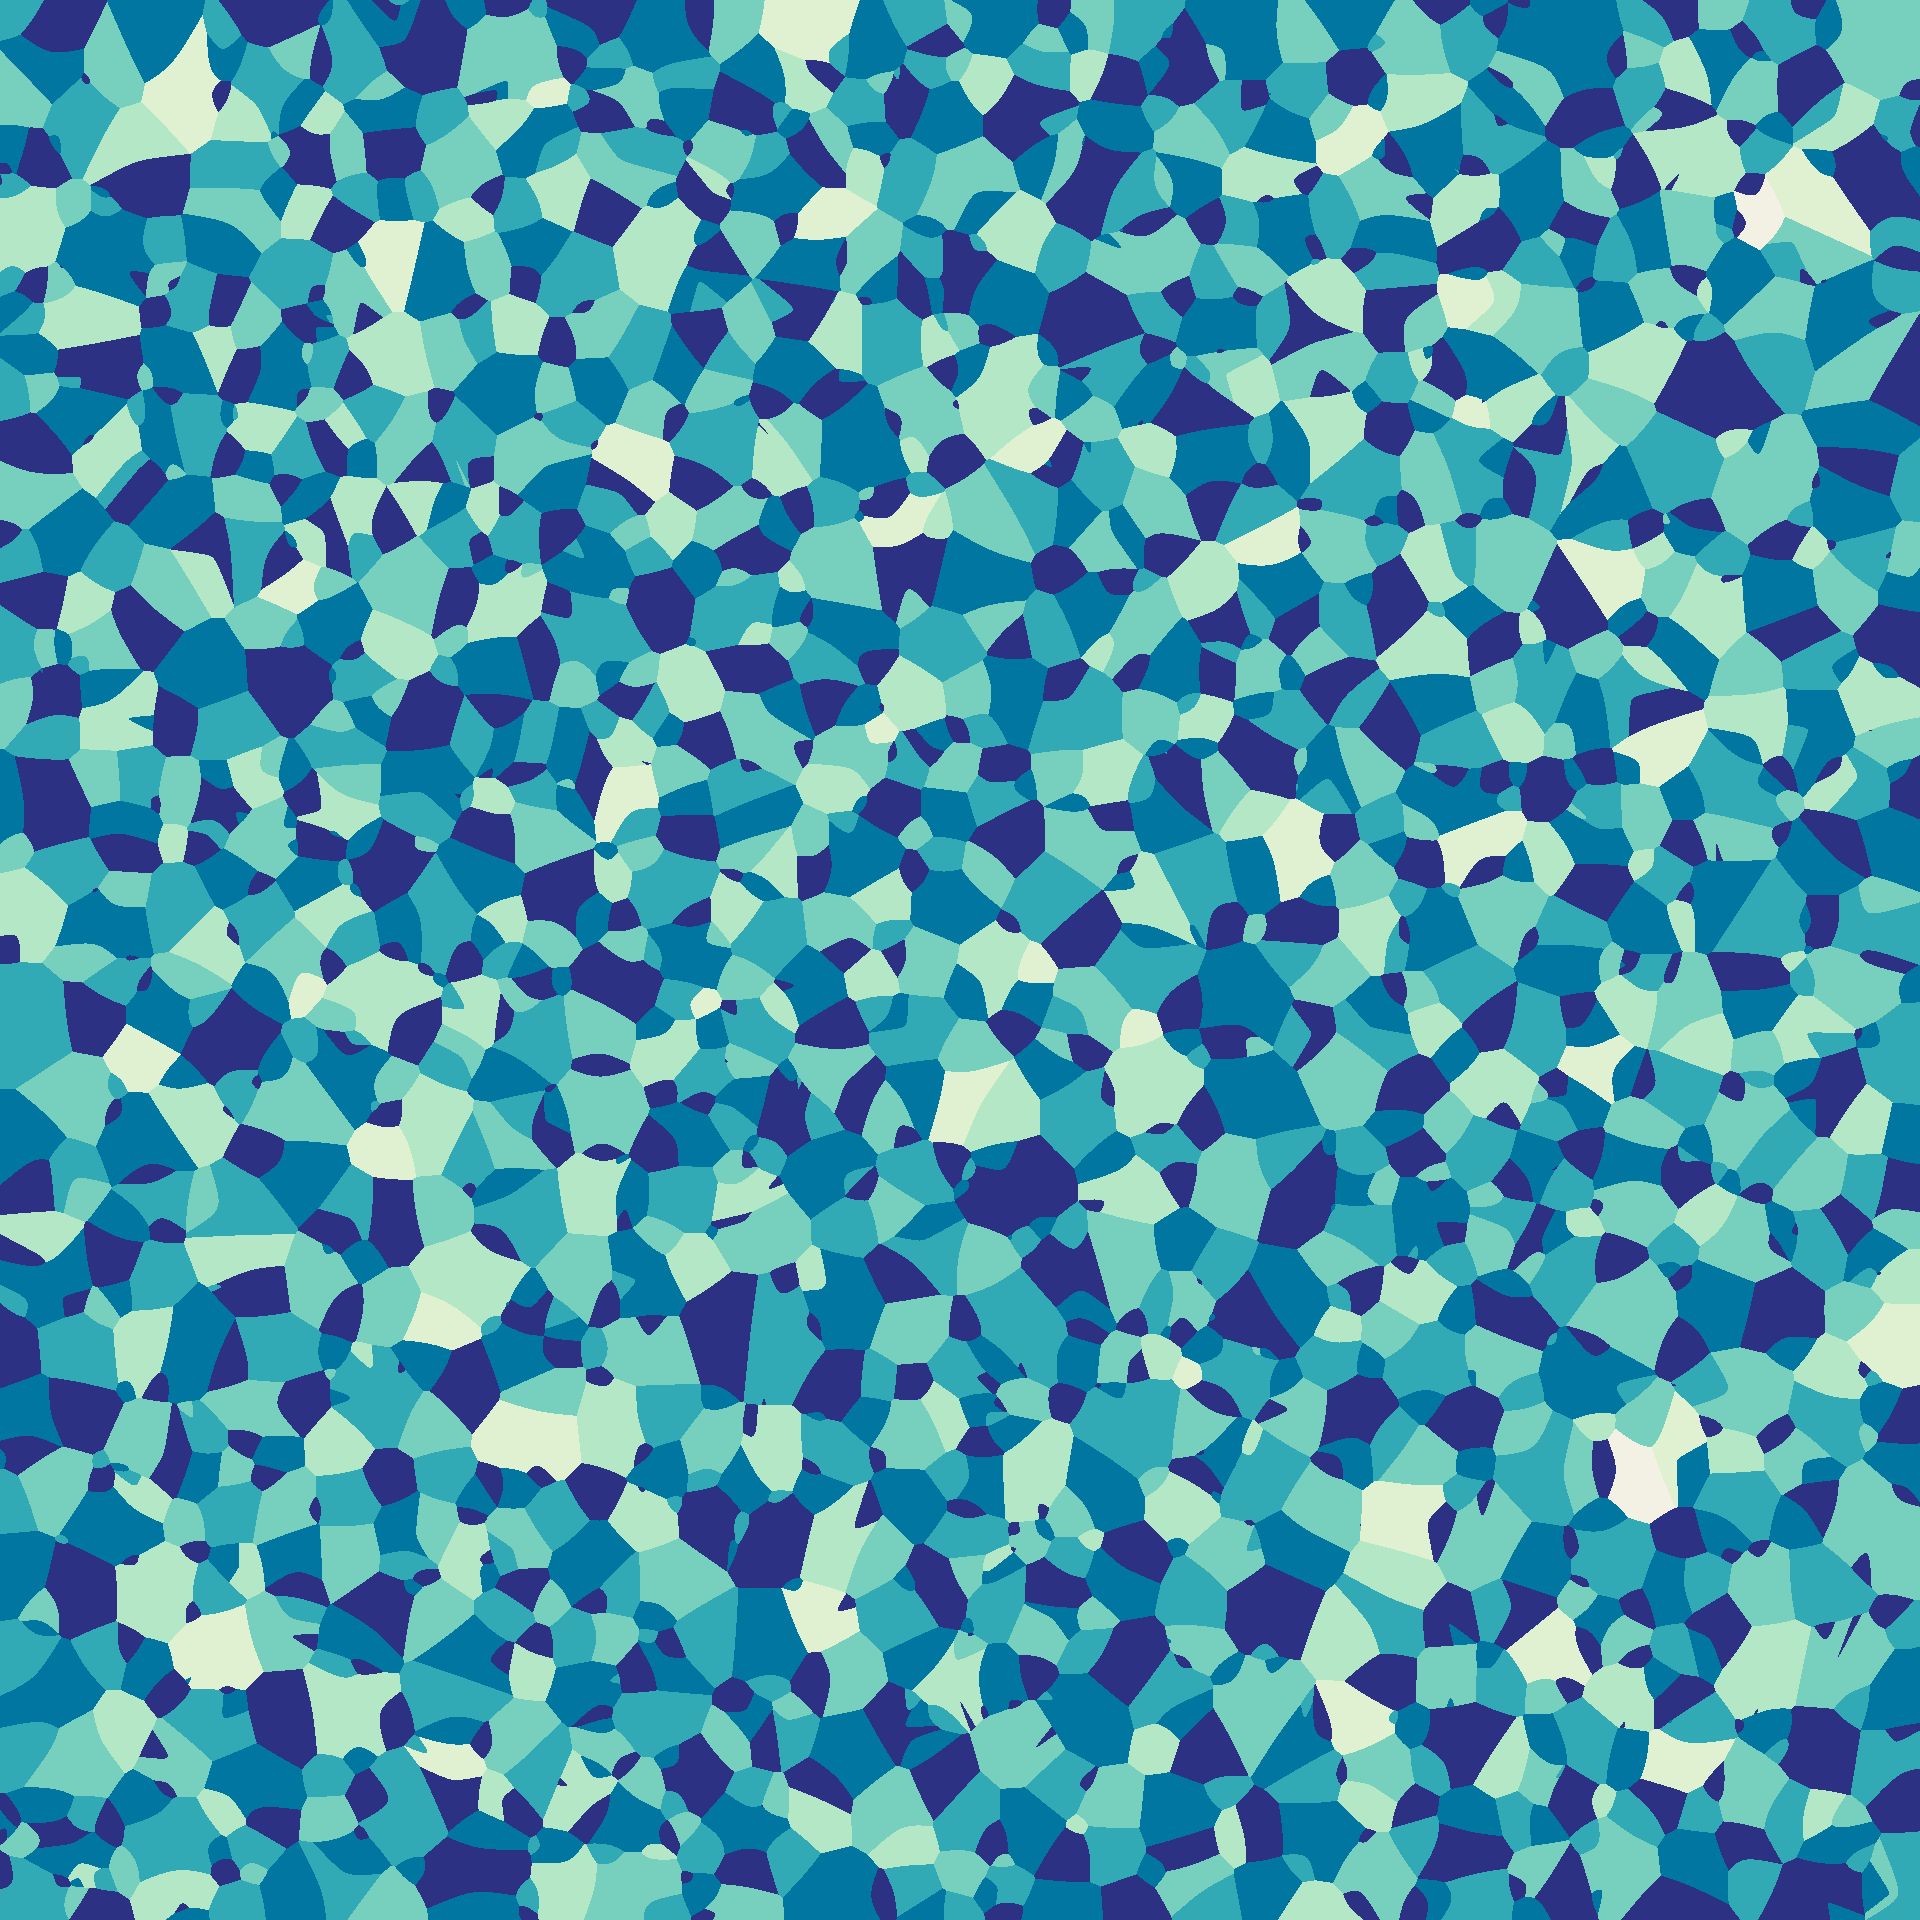

In [13]:
from PIL import Image, ImageColor

hex_colours = c(max(colours.values())+1)
rgb_colours = [ImageColor.getcolor(col,"RGB") for col in hex_colours]

data = np.empty((img_size, img_size, 3), dtype=np.uint8)
N = I.shape[0]
for i in range(N):
    for j in range(N):
        data[i,j,:] = rgb_colours[colours[I[i,j]]]

image = Image.fromarray(data)
# image.show() # opens in system image viewer
display(image)

In [15]:
image.show()